# Word Embeddings, T-SNE, and product Similarity using Word2Vec

## Imports <a name="im"></a>

In [1]:
import os

%matplotlib inline
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.set_option("display.max_colwidth", 0)

## Exploring pre-trained word embeddings
<hr>

Here I will use pre-trained word embeddings from the [GloVe](https://nlp.stanford.edu/pubs/glove.pdf) algorithm. The specific embeddings I will look at are trained on a corpus from Wikipedia, found [here](https://nlp.stanford.edu/projects/glove/). I plan to explore these pre-trained embeddings to find explore word relatedness and analogies.

In [2]:
import gensim
import gensim.downloader

print(list(gensim.downloader.info()["models"].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


I will be using the GloVe Wikipedia vectors, which has the key `glove-wiki-gigaword-100`.

In [3]:
import gensim.downloader as api

glove_wiki_vectors = api.load(
    "glove-wiki-gigaword-100"
)

In [4]:
len(glove_wiki_vectors)

400000

There are 400,000 word vectors in these pre-trained model. 

In [5]:
glove_wiki_vectors["learning"].shape

(100,)

Each vector is 100 dimensional, and below you can see most similar words to the word _learning_.

In [6]:
glove_wiki_vectors.most_similar("learning")

[('teaching', 0.7720069289207458),
 ('knowledge', 0.76064133644104),
 ('experience', 0.7378624677658081),
 ('skills', 0.7343750596046448),
 ('learn', 0.7340658903121948),
 ('understanding', 0.699902355670929),
 ('education', 0.6989467740058899),
 ('educational', 0.6864885687828064),
 ('lessons', 0.681064784526825),
 ('studying', 0.6762653589248657)]

<br><br>

### Word relatedness using cosine similarity

In [7]:
word_pairs = [
    ("coast", "shore"), # Expect high similarity
    ("clothes", "closet"), # Expect high sim.
    ("old", "new"), # Expect decently high sim.
    ("smart", "intelligent"), # Expect high sim.
    ("dog", "cat"), # Expect high sim.
    ("tree", "lawyer"), # Expect low sim.
]

In [8]:
for pair in word_pairs:
    print("Similarity between %s and %s is %.3F" 
         % (pair[0], pair[1], glove_wiki_vectors.similarity(pair[0],pair[1])))
    

Similarity between coast and shore is 0.700
Similarity between clothes and closet is 0.546
Similarity between old and new is 0.643
Similarity between smart and intelligent is 0.755
Similarity between dog and cat is 0.880
Similarity between tree and lawyer is 0.077


The model appears to score the word pairs effectively, as words that I know to be similar were given high cosine similarity scores, while the word pair _tree_ and _lawyer_ scored quite low as they are not very similar in any context.

### Finding words that don't belong

Using the `doesnt_match` method from the word vectors class, the model can effectively determine which word has the word vector furthest away from the other three words.

In [10]:
print(glove_wiki_vectors.doesnt_match("car bicycle plane skateboard".split()))
print(glove_wiki_vectors.doesnt_match("blue red green crimson".split()))
print(glove_wiki_vectors.doesnt_match("one two three ninety".split()))

plane
crimson
ninety


The words that I intended to be outliers compared to the other words were all picked up, which is reassuring to see.

<br><br>

### Representation of all words in English

1. The vocabulary size of Wikipedia embeddings is quite large. The `test_words` list below contains a few new words (called neologisms) and biomedical domain-specific abbreviations. Write code to check whether `glove_wiki_vectors` has representation for these words or not. 
2. Give example corpora (collection of texts) that you would use to train word2vec models so that you have representations for these words.   

> If a given word `word` is in the vocabulary, `word in glove_wiki_vectors` will return True. 

In [11]:
test_words = [
    "covididiot",
    "fomo",
    "frenemies",
    "anthropause",
    "photobomb",
    "selfie",
    "pxg",  # Abbreviation for pseudoexfoliative glaucoma
    "pacg",  # Abbreviation for primary angle closure glaucoma
    "cct",  # Abbreviation for central corneal thickness
    "escc",  # Abbreviation for esophageal squamous cell carcinoma
]

<div class="alert alert-warning">

Solution_1_3_1
    
</div>

In [12]:
for word in test_words:
    print("%s has representation in glove_wiki_vectores : %r" % (word, word in glove_wiki_vectors))


covididiot has representation in glove_wiki_vectores : False
fomo has representation in glove_wiki_vectores : False
frenemies has representation in glove_wiki_vectores : True
anthropause has representation in glove_wiki_vectores : False
photobomb has representation in glove_wiki_vectores : False
selfie has representation in glove_wiki_vectores : False
pxg has representation in glove_wiki_vectores : False
pacg has representation in glove_wiki_vectores : False
cct has representation in glove_wiki_vectores : True
escc has representation in glove_wiki_vectores : True


<div class="alert alert-warning">

Solution_1_3_2
    
</div>

For the first 5 words that are not represented I would use a collection of tweets or other social media text that incorporates the use of them. The last 2 I would suggest using medical notes, or relevant wikipedia articles that reference the real word and the abbreviations together.

<br><br><br>

### 1.4 Visualizing similar words
rubric={viz:5,reasoning:2}

Let's examine the quality of embeddings by visualizing whether similar words are close together in the vector space or not. 
Our word vectors are 100 dimensional and if we want to visualize them, we need to reduce dimensionality to 3 dimensions or 2 dimensions. [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) would be a simplest approach for this. For better visualization, we can also use non-linear dimensionality reduction techniques such as [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) or [UMAP](https://umap-learn.readthedocs.io/en/latest/). In this exercise, you'll use PCA and t-SNE to visualize a sample of word embeddings and compare the visualizations.  

The code below extracts word embeddings for a set of 66 words from 6 categories and stores them in the dataframe `embeddings_df`, where indices are words. 

> Feel free to experiment with the categories but in your final submission keep these categories so that it's easier for the TAs to grade your work.  

**Your tasks:**

1. Apply PCA to `embeddings_df` below to reduce dimensionality to 2 dimensions and show a scatter plot of reduced dimensions. Add labels (words) to the points in the plot.  
2. Apply t-SNE to `embeddings_df` below to reduce dimensionality to 2 dimensions and show a scatter plot of reduced dimensions. Add labels (words) to the points in the plot. 
3. Compare the scatter plots created by PCA and t-SNE and briefly discuss your observations. 

> For t-SNE, you might have to tune some hyperparameters. Show your work or briefly justify your choices. 

> Feel free to use code from lecture notes with appropriate attributions. 

In [13]:
# Create words and labels.

categories = ["english", "apple", "intelligence", "hockey", "cobain", "pca"]
subset_words = []

labels = []
j = 0
for cat in categories:
    subset_words.append(cat)
    labels.append(j)
    for similar_word, _ in glove_wiki_vectors.most_similar(cat, topn=10):
        subset_words.append(similar_word)
        labels.append(j)
    j += 1

In [14]:
embeddings_df = pd.DataFrame(data=glove_wiki_vectors[subset_words], index=subset_words)
embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
english,-0.05386,0.446860,0.250770,0.069087,-0.299940,1.10950,0.029171,-1.08110,-0.43389,0.502380,...,-0.49669,-0.24979,0.02899,0.87748,-0.56759,0.121130,-0.612610,-0.23581,0.167250,-0.29405
welsh,-0.32721,0.278950,-0.003277,-0.608470,-0.238010,0.60569,-0.351510,-0.60151,-0.63245,-0.268170,...,-0.66202,-0.42692,-0.35276,1.06300,-0.58287,0.108040,-0.225330,0.13710,0.040706,-0.40040
language,0.18519,0.341110,0.360970,0.270930,-0.031335,0.83923,-0.505340,-0.80062,0.40695,0.824880,...,0.13560,0.09430,-0.24154,0.71230,-0.42010,0.247350,-0.944490,-1.07940,0.341300,0.34704
irish,-0.18177,0.430810,0.330500,-0.342800,-0.154820,1.12950,0.025862,-1.21580,-0.50898,-0.155890,...,-0.86785,-0.56849,-0.76525,0.62210,-0.94863,-0.261130,-0.151510,0.60873,0.339210,-0.13511
scottish,-0.58938,-0.056929,0.342550,-0.124950,0.302700,0.77937,-0.057956,-0.99580,-1.25450,-0.094012,...,-0.60198,-0.75949,-0.50064,0.84948,-0.44227,0.033158,-0.071143,0.51388,0.205080,-1.05190


In [15]:
embeddings_df.shape

(66, 100)

<div class="alert alert-warning">

Solution_1_4_1
    
</div>

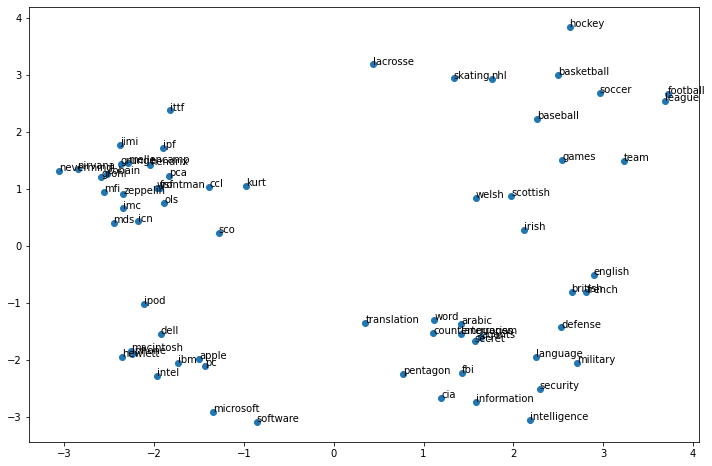

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(embeddings_df)
emb_pca = pd.DataFrame(pca.transform(embeddings_df), index=embeddings_df.index)

fig, ax = plt.subplots()
fig.set_size_inches(12,8)
ax.scatter(emb_pca.iloc[:,0], emb_pca.iloc[:,1])
for i, txt in enumerate(emb_pca.index):
    ax.annotate(txt, (emb_pca.iloc[i,0], emb_pca.iloc[i,1]))

<div class="alert alert-warning">

Solution_1_4_2
    
</div>

/Users/samquist/miniconda3/envs/563/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/samquist/miniconda3/envs/563/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


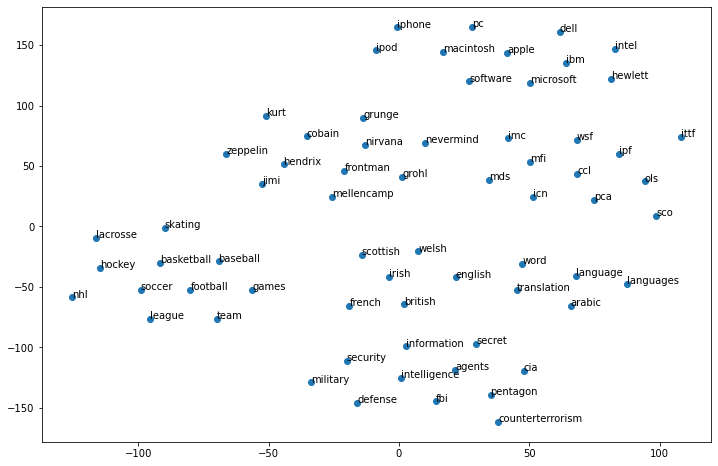

In [17]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_df = pd.DataFrame(tsne.fit_transform(embeddings_df), index=embeddings_df.index)

fig, ax = plt.subplots()
fig.set_size_inches(12,8)
ax.scatter(tsne_df.iloc[:,0], tsne_df.iloc[:,1])
for i, txt in enumerate(tsne_df.index):
    ax.annotate(txt, (tsne_df.iloc[i,0], tsne_df.iloc[i,1]))

<div class="alert alert-warning">

Solution_1_4_3
    
</div>

The groups in t-SNE appear to be more evenly spaced, and the groups can easily been seen. For example, there is a software group, a musical artist group and a sports group while in the pca plot the groups are not uniformly spaced. Furthermore, the pca plot has numerous data points that are in-between groups or not in the most sensible group. For example, Welsh, Irish and Scottish are closer to "games" than "English".

<br><br>

<br><br><br><br>

## Exercise 2: Stereotypes and biases in word embeddings
<hr>

### 2.1 Potential effect of stereotypes and biases in embeddings
rubric={reasoning:2}

Word vectors contain lots of useful information. But they also contain stereotypes and biases of the texts they were trained on. In the lecture, we saw that our pre-trained word embedding model output an analogy that reinforced a gender stereotype.

**Your tasks:**

1. Give an example of how using such a model could cause harm in the real world.

<div class="alert alert-warning">

Solution_2_1_1
    
</div>

If the model was trained to parse job applications/cover letters, it could easily discriminate against people who include certain words in their applications. 

<br><br>

### 2.2 Stereotypes and biases in embeddings
rubric={accuracy:2,reasoning:4}

**Your tasks:**

1. Here we are using pre-trained embeddings which are built using Wikipedia data. Explore whether there are any worrisome biases or stereotypes present in these embeddings or not by trying out at least 4 examples. You can use the following two methods or other methods of your choice to explore what kind of stereotypes and biases are encoded in these embeddings. 
    - use the `analogy` function below which gives word analogies (an example shown below)
    - use [similarity](https://radimrehurek.com/gensim/models/keyedvectors.html?highlight=similarity#gensim.models.keyedvectors.KeyedVectors.similarity) or [distance](https://radimrehurek.com/gensim/models/keyedvectors.html?highlight=distance#gensim.models.keyedvectors.KeyedVectors.distances) methods (an example is shown below.)   
2. Discuss your observations.

> Note that most of the recent embeddings are de-biased. But you might still observe some biases in them. Also, not all stereotypes present in pre-trained embeddings are necessarily bad. But you should be aware of them when you use them in your models. 

An example of using word analogies to explore biases and stereotypes.

In [18]:
def analogy(word1, word2, word3, model=glove_wiki_vectors):
    """
    Returns analogy word using the given model.

    Parameters
    --------------
    word1 : (str)
        word1 in the analogy relation
    word2 : (str)
        word2 in the analogy relation
    word3 : (str)
        word3 in the analogy relation
    model :
        word embedding model

    Returns
    ---------------
        pd.dataframe
    """
    print("%s : %s :: %s : ?" % (word1, word2, word3))
    sim_words = model.most_similar(positive=[word3, word2], negative=[word1])
    return pd.DataFrame(sim_words, columns=["Analogy word", "Score"])

In [19]:
analogy("man", "doctor", "woman")

man : doctor :: woman : ?


,Analogy word,Score
0,nurse,0.773523
1,physician,0.718943
2,doctors,0.682433
3,patient,0.675068
4,dentist,0.672603
5,pregnant,0.664246
6,medical,0.652045
7,nursing,0.645348
8,mother,0.639333
9,hospital,0.638750


An example of using similarity between words to explore biases and stereotypes.

In [20]:
glove_wiki_vectors.similarity("white", "poor")

0.4408384

In [21]:
glove_wiki_vectors.similarity("black", "poor")

0.50771147

<div class="alert alert-warning">

Solution_2_2_1
    
</div>

In [22]:
analogy("man", "smart", "woman")

man : smart :: woman : ?


,Analogy word,Score
0,intelligent,0.654885
1,sexy,0.597897
2,sophisticated,0.574362
3,mom,0.557256
4,cute,0.549813
5,kids,0.540299
6,pretty,0.530862
7,savvy,0.530233
8,innovative,0.530197
9,attractive,0.528517


In [23]:
print(glove_wiki_vectors.similarity("man", "rich"))
print(glove_wiki_vectors.similarity("woman", "rich"))

0.46977922
0.3507729


In [24]:
print(glove_wiki_vectors.similarity("man", "kind"))
print(glove_wiki_vectors.similarity("woman", "kind"))

0.6737176
0.5527537


In [25]:
analogy("man", "strong", "woman")

man : strong :: woman : ?


,Analogy word,Score
0,stronger,0.726966
1,weak,0.657428
2,robust,0.644944
3,strongest,0.634013
4,despite,0.631509
5,support,0.627726
6,growing,0.625404
7,concern,0.605287
8,particularly,0.603681
9,reflected,0.600039


<div class="alert alert-warning">

Solution_2_2_2
    
</div>

The analogy comparisons were good for the top result, but the second result is what I found to show negative bias. When comparing man to smart, the model says that 'sexy' was the second highest scoring word for women, and fairly close to 'intelligent'. The same goes for the second analogy where the first suggestion is good but the second one shows bias. The two similarity vector comparisons were both biased towards being higher for men, despite both similarity words being truly neutral adjectives.

<br><br>

### (optional) 2.3 Exploring stereotypes using WEAT 
rubric={reasoning:1}

The standard way to identify embedding bias is using WEAT (Word Embedding Association Test), which comes from a [Science paper](https://purehost.bath.ac.uk/ws/portalfiles/portal/168480066/CaliskanEtAl_authors_full.pdf) from a few years ago. It is adapted from psychological tests for detecting implicit bias. 

The basic idea is that you take some representative target words (e.g., `men_words` and `women_words`) and attribute words (e.g., `high_pay_jobs_words`, `low_pay_jobs_words`), as shown below. Then we calculate a normalized z-score like effect, which is positive if bias is as expected and a p-value based on trying all groupings of the words in the targets. 

If you're interested in details, here is the [paper](https://purehost.bath.ac.uk/ws/portalfiles/portal/168480066/CaliskanEtAl_authors_full.pdf) and [here](https://github.com/kmccurdy/w2v-gender/tags) is the Python implementation of WEAT. 

**Your tasks**

1. Explore embedding biases using WEAT for target and attribute words of your choosing using the Python implementation [here](https://github.com/kmccurdy/w2v-gender/tags). 

> You are likely to discuss this more in your ethics course next block.   

In [26]:
men_words = {"male", "man", "boy", "he", "him", "his"}

In [27]:
women_words = {"female", "woman", "girl", "she", "her", "hers"}

In [28]:
high_pay_jobs_words = {"doctor", "lawyer", "programmer", "surgeon", "executive"}

In [29]:
low_pay_jobs_words = {"nurse", "janitor", "cashier", "driver"}

<div class="alert alert-warning">

Solution_2_3_1
    
</div>

<br><br><br><br>

## Exercise 3: Building your own embeddings <a name="2"></a>
<hr>

When you work in specific domains, you might need to train your own word embeddings. In this exercise, you will train your own embeddings on a biomedical corpus using [`gensim`](https://radimrehurek.com/gensim/). 

We'll use a small subset of a corpus of [biomedical abstracts downloaded from PMC](https://www.kaggle.com/cvltmao/pmc-articles?select=a_b.csv). The original corpus is large and to get meaningful embeddings, we would ideally use the full corpus. But for the purpose of this assignment, we will only work on a sample for speed. 

**Your tasks:**

- Download `a_b.csv` from [kaggle](https://www.kaggle.com/cvltmao/pmc-articles?select=a_b.csv), and put it in the lab folder. 
- Run the code below which reads the CSV and extracts a sample of the CSV. 

In [30]:
df = pd.read_csv("a_b.csv")
df = df.dropna()
df_subset = df.sample(5000, random_state=42)

In [31]:
df_subset.head()

,article_id,abstract
129637,PMC3537527,"Esophageal squamous cell carcinoma (ESCC) shows a 5-year survival rate below 10%, demonstrating the urgency in improving its treatment. Alterations in epidermal growth factor receptors are closely related to malignancy transformation in a number of tumors and recent successful targeted therapies have been directed to these molecules. Therefore, in this study, we analyzed the expression of EGFR and HER2 and evaluated mutation profile as well as the presence of mutations in hotspots of and in ESCC patients. We performed RT-qPCR, immunohistochemistry and Fluorescent hybridization to determine EGFR and HER2 expression in ESCC patients, and direct sequencing and PCR-RFLP for mutations and polymorphism analysis Our results showed an increased mRNA expression in tumors compared to surrounding tissue (p <0.05), with 11% of the cases presenting at least a four-fold difference between tumor and paired adjacent mucosa. EGFR protein overexpression was present only in 4% of the cases. The median expression of mRNA was not different between tumors and adjacent mucosa. Still, 7% of the tumors presented at least a 25-fold higher expression of this gene when compared to its paired counterpart. Immunohistochemical analysis revealed that 21% of the tumors were positive for HER2 (scores 2+ and 3+), although only 3+ tumors presented amplification of this gene. Mutation analysis for (exons 18-21), (codons 12 and 13) and (V600E) showed no mutations in any of the hotspots of these genes in almost 100 patients analyzed. presented synonymous polymorphisms at codon 836 (C>T) in 2.1% of the patients, and at codon 787 (G>A) in 79.2% of the cases. This last polymorphism was also evaluated in 304 healthy controls, which presented a similar frequency (73.7%) in comparison with ESCC patients. The absence of mutations of , and as well as the overexpression of EGFR and HER2 in less than 10% of the patients suggest that this signaling pathway is altered in only a small proportion of patients with ESCC. HER receptors target therapies may have the potential to be effective in only a minor fraction of patients with ESCC."
234041,PMC2711088,"Asthma is the most common chronic disease in childhood, characterized by chronic airway inflammation. There are problems with the diagnosis of asthma in young children since the majority of the children with recurrent asthma-like symptoms is symptom free at 6 years, and does not have asthma. With the conventional diagnostic tools it is not possible to differentiate between preschool children with transient symptoms and children with asthma. The analysis of biomarkers of airway inflammation in exhaled breath is a non-invasive and promising technique to diagnose asthma and monitor inflammation in young children. Moreover, relatively new lung function tests (airway resistance using the interrupter technique) have become available for young children. The primary objective of the ADEM study (Asthma DEtection and Monitoring study), is to develop a non-invasive instrument for an early asthma diagnosis in young children, using exhaled inflammatory markers and early lung function measurements. In addition, aetiological factors, including gene polymorphisms and gene expression profiles, in relation to the development of asthma are studied. A prospective case-control study is started in 200 children with recurrent respiratory symptoms and 50 control subjects without respiratory symptoms. At 6 years, a definite diagnosis of asthma is made (primary outcome measure) on basis of lung function assessments and current respiratory symptoms ('golden standard'). From inclusion until the definite asthma diagnosis, repeated measurements of lung function tests and inflammatory markers in exhaled breath (condensate), blood and faeces are performed. The study is registered and ethically approved. This article describes the study protocol of the ADEM study. The new diagnostic techniques applied in this study could 

Word2Vec requires data to be in a specific format, as shown below.

```
[[sent1word1, sent1word2, ...], 
 [sent2word1, sent2word2, ...], 
 ...
 [sent1000word1, sent1000word2, ...],
 ...
 ]
 
```

`Gensim`, the package we are using to train Word2Vec, only requires that the input provides sentences sequentially, when iterated over. There is no need to keep everything in RAM. So we can provide one sentence, process it, forget it, load another sentence.

The `preprocessing.py` file has class `MyPreprocessor` which preprocesses a given list of documents and **yields a memory-friendly iterator** for text which you can pass to Word2Vec model. The preprocessing carries out the following steps:

- sentence segmentation
- tokenization
- turned the text into lowercase
- removing stopwords

The purpose of preprocessing is to "normalize" the text so that equivalent things (e.g., _Data_ and _data_) with respect to your task match with each other. 

Run the code below to carry out preprocessing of the corpus. 

In [32]:
import nltk
nltk.download('stopwords')
from preprocessing import MyPreprocessor

corpus = df_subset["abstract"].tolist()
sentences = MyPreprocessor(corpus)  # memory friendly iterator

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samquist/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<br><br>

###  3.1 Training `Word2Vec` and `fastText`
rubric={accuracy:3,reasoning:2}

Now that we have an iterator of the data in the expected format, let's train our own word embeddings. In this exercise, you will train `Word2Vec` and `fastText` models on `sentences` iterator above. 

**Your tasks:** 

1. Train [Word2Vec model](https://radimrehurek.com/gensim/models/word2vec.html) on `sentences` with the following hyperparameters. (This might take some time so I recommend saving the model with `model.save` for later use. See usage example [here](https://radimrehurek.com/gensim/models/word2vec.html#usage-examples).)
    * `vector_size=100`
    * `window=5`
    * `min_count=2`,
2. Train [fastText model](https://radimrehurek.com/gensim/models/fasttext.html) on `sentences` with the same hyperparameters above. (This might take some time so I recommend saving the model for later use.)


> Note that the word embeddings will be better quality if we use the full corpus instead of the subset. We are using a subset in this exercise to save time. On my iMac it took ~60 s to train Word2Vec and ~65 s to train fastText on the sample above. If you are feeling adventurous and if your computer can handle it, you are welcome to train it on the full corpus. If your computer is struggling to create embeddings with 5000 documents, reduce the sample size.    

> **Please do not submit your saved models.**

In [33]:
from gensim.models import FastText, Word2Vec

<div class="alert alert-warning">

Solution_3_1_1
    
</div>

In [34]:
model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=2)


<div class="alert alert-warning">

Solution_3_1_2
    
</div>

In [35]:
from gensim.models import FastText
model2 = FastText(sentences=sentences, vector_size=100, window=5, min_count=2)

### 3.2 
rubric={accuracy:1,reasoning:2}

**Your tasks:**
1. What is the vocabulary size in each of the models above? 
2. Give one or two example scenarios when you would train your own embeddings vs. when you would use pre-trained embeddings.   

> You might have to access the vocabulary size as `len(model.wv)` and word vectors as `model.wv[word]`, if `model` is your trained model. 

<div class="alert alert-warning">

Solution_3_2_1
    
</div>

In [36]:
len(model.wv), len(model2.wv)

(29910, 29910)

<div class="alert alert-warning">

Solution_3_2_2
    
</div>

I would train my own embeddings when using text data that contains many new words and it is important that the words are not misrepresented by breaking them down into smaller embeddings, like a medical corpus.

<br><br>

### 3.3 Unknown words 
rubric={accuracy:2,reasoning:2}

1. Below are the test words we tried before. Write code to check which of these words have representations in our trained embeddings. Try both word2vec and fasttext models you have trained above. 
2. Discuss your observations. 

> Note that you might have to access word vector for a word `word` as `model.wv['word']` if `model` is your trained model. 

In [37]:
test_words = [
    "covididiot",
    "fomo",
    "frenemies",
    "anthropause",
    "photobomb",
    "selfie",
    "pxg",  # Abbreviation for pseudoexfoliative glaucoma
    "pacg",  # Abbreviation for primary angle closure glaucoma
    "cct",  # Abbreviation for central corneal thickness
    "escc",  # Abbreviation for esophageal squamous cell carcinoma
]

<div class="alert alert-warning">

Solution_3_3_1
    
</div>

In [38]:
for word in test_words:
    try:
        model.wv['{}'.format(word)]
        invec = True
    except Exception:
        invec = False
    print("%s is in w2v model: %r" % (word, invec))
    print("%s is in ft model: %r \n" % (word, word in model2.wv))

covididiot is in w2v model: False
covididiot is in ft model: True 

fomo is in w2v model: False
fomo is in ft model: True 

frenemies is in w2v model: False
frenemies is in ft model: True 

anthropause is in w2v model: False
anthropause is in ft model: True 

photobomb is in w2v model: False
photobomb is in ft model: True 

selfie is in w2v model: False
selfie is in ft model: True 

pxg is in w2v model: True
pxg is in ft model: True 

pacg is in w2v model: True
pacg is in ft model: True 

cct is in w2v model: True
cct is in ft model: True 

escc is in w2v model: True
escc is in ft model: True 



<div class="alert alert-warning">

Solution_3_3_2
    
</div>

We can see above that all the medical abbreviations are present in the word2vec vocab, but the neolisms are not. In the fasttext model, all of the words tested were in the vocabulary as fasttext creates mini embeddings from larger words.

<br><br><br><br>

## Exercise 4: Product recommendation using Word2Vec
<hr>

The Word2Vec algorithm can also be used in tasks beyond text and word similarity. In this exercise we will explore using it for product recommendations. We will build a Word2Vec model so that similar products (products occurring in similar contexts) occur close together in the vector space. The context of products can be determined by the purchase histories of customers. Once we have reasonable representation of products in the vector space, we can recommend products to customers that are "similar" (as depicted by the algorithm) to their previously purchased items. 

For this exercise, we will be using the [Online Retail Data Set from UCI ML repo](https://www.kaggle.com/jihyeseo/online-retail-data-set-from-uci-ml-repo#__sid=js0). The starter code below reads the data as a pandas dataframe `df`. 

> You might have to install `openpyxl` in your `conda` environment to open the `xlsx` file. 

```
conda install openpyxl
```
Download the data and save it in your lab directory. **Please do not push the data to your repository.** 

Run the code below which reads the data and carries out basic preprocessing. 

In [39]:
df = pd.read_excel("Online_Retail.xlsx")  # Takes a while to read the data.

In [40]:
print("Data frame shape: ", df.shape)
df.head()

Data frame shape:  (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [41]:
df.dropna(inplace=True)
print("Shape after dropping rows with NaNs: ", df.shape)

# Convert StockCode and CustomerID columns to strings
df["StockCode"] = df["StockCode"].astype(str)
df["CustomerID"] = df["CustomerID"].astype(str)

Shape after dropping rows with NaNs:  (406829, 8)


In [42]:
df['StockCode'][df['CustomerID']=="17850.0"]

0        85123A
1        71053 
2        84406B
3        84029G
4        84029E
          ...  
86898    82483 
86899    21874 
86900    71477 
86901    82483 
86902    21169 
Name: StockCode, Length: 312, dtype: object

<br><br>

### 4.1 Prepare data for Word2Vec
rubric={accuracy:4,quality:2}

Remember that word2vec requires data in the following form. 

```
[[sent1word1, sent1word2, ...], 
 [sent2word1, sent2word2, ...], 
 ...
 [sent1000word1, sent1000word2, ...],
 ...
 ]
 
```
In this context, customer purchase histories for unique customers are equivalent to sentences and stock codes are equivalent to words.   

**Your tasks:**
1. How many unique customers and unique products are present in the data above? 
2. For all unique customers, create purchasing histories for them in the following format, where each inner list corresponds to the purchase history of a unique customer. Each item in the list is a `StockCode` in the purchase history of that customer, ordered by the time of purchase. 

```
[[StockCode1_of_CustomerID1, StockCode2_of_CustomerID1, ....], 
 [StockCode1_of_CustomerID2, StockCode2_of_CustomerID2, ....], 
 ...
 [StockCode1_of_CustomerID1000, StockCode2_of_CustomerID1000, ....],
 ...
 ]
 
```

<div class="alert alert-warning">

Solution_4_1_1
    
</div>

In [43]:
unique_cust_id = set(df['CustomerID'])
len(unique_cust_id),len(set(df['StockCode']))

(4372, 3684)

<div class="alert alert-warning">

Solution_4_1_2
    
</div>

In [44]:
stockcode_list = [None] * 4372
for i, cust in enumerate(unique_cust_id):
    stockcode_list[i] = list(df['StockCode'][df['CustomerID']==str(cust)])

<br><br>

### 4.2 Train `Word2Vec` model 
rubric={accuracy:3}

**Your tasks:**
1. Now that your data is in the format suitable for training Word2Vec model, train `Word2Vec` model with the following hyperparameters
    - `window=10` 
    - `negative=10` (for negative sampling)
    - `seed=8` 
    - `min_count=1`

<div class="alert alert-warning">

Solution_4_2_1
    
</div>

In [45]:
model = Word2Vec(sentences=stockcode_list, window=10, negative=10, seed=8, min_count=1)

<br><br>

### 4.3 Examine product similarity 
rubric={accuracy:3,reasoning:2}

Given a word2vec model trained on purchase history data and product description, the function `get_most_similar` below returns descriptions of top `n` most similar products. 

**Your tasks:**
1. Get similar products for the following products. 
    - 'SWIRLY CIRCULAR RUBBERS IN BAG'
    - 'POLKADOT RAIN HAT'    
2. Now pick 4 product descriptions of your choice from the data. Call `get_most_similar` for these product descriptions and examine similar products returned by the function.
3. Do the recommendations given by the model make sense? Discuss your observations. 

In [46]:
# Create products id_name and name_id dictionaries
products_id_name_dict = pd.Series(
    df.Description.str.strip().values, index=df.StockCode
).to_dict()
products_name_id_dict = pd.Series(
    df.StockCode.values, index=df.Description.str.strip()
).to_dict()

In [47]:
def get_most_similar(prod_desc, n=10, model=model):
    """
    Given product description, prod_desc, return the most similar
    products

    Parameters
    ---------
    prod_desc : str
        Product description

    n : integer
        the number of similar items to return

    model : gensim Word2Vec model
        trained gensim word2vec model on customer purchase histories

    Returns
    -------
    pandas.DataFrame
        A pandas dataframe containing n names of similar products
        and their similarity scores with the input product
        with desciption prod_desc.

    """
    stock_id = products_name_id_dict[prod_desc]
    try:
        similar_stock_ids = model.wv.most_similar(stock_id, topn=n)
    except:
        print("The product %s is not in the vocabulary" % (prod_desc))
        return

    similar_prods = []

    for (sim_stock_id, score) in similar_stock_ids:
        similar_prods.append((products_id_name_dict[sim_stock_id], score))
    return pd.DataFrame(
        similar_prods, columns=["Product description", "Similarity score"]
    )

<div class="alert alert-warning">

Solution_4_3_1
    
</div>

In [48]:
get_most_similar('SWIRLY CIRCULAR RUBBERS IN BAG')

,Product description,Similarity score
0,DOGGY RUBBER,0.969028
1,LETTER SHAPE PENCIL SHARPENER,0.960787
2,GLOW IN DARK DOLPHINS,0.935482
3,PARTY TIME PENCIL ERASERS,0.934336
4,KITTY PENCIL ERASERS,0.928729
5,PIECE OF CAMO STATIONERY SET,0.927105
6,CARTOON PENCIL SHARPENERS,0.923729
7,HOUSE SHAPE PENCIL SHARPENER,0.921840
8,TEATIME PEN CASE & PENS,0.916180
9,SWEET PUDDING STICKER SHEET,0.915108


In [49]:
get_most_similar('POLKADOT RAIN HAT')

,Product description,Similarity score
0,RAIN PONCHO RETROSPOT,0.903114
1,MONEY BOX BISCUITS DESIGN,0.876143
2,MONEY BOX KINGS CHOICE DESIGN,0.812342
3,MONEY BOX POCKET MONEY DESIGN,0.775808
4,CHOCOLATE CALCULATOR,0.769225
5,MONEY BOX FIRST AID DESIGN,0.758341
6,KIDS RAIN MAC BLUE,0.725978
7,BIRTHDAY PARTY CORDON BARRIER TAPE,0.725626
8,SET 12 KIDS COLOUR CHALK STICKS,0.721619
9,PACK 6 HEART/ICE-CREAM PATCHES,0.720599


<div class="alert alert-warning">

Solution_4_3_2
    
</div>

In [50]:
get_most_similar('ASSORTED BOTTLE TOP  MAGNETS')

,Product description,Similarity score
0,FRIDGE MAGNETS US DINER ASSORTED,0.914275
1,FRIDGE MAGNETS LES ENFANTS ASSORTED,0.874610
2,JAM CLOCK MAGNET,0.811240
3,FRIDGE MAGNETS LA VIE EN ROSE,0.805365
4,GLASS JAR MARMALADE,0.786324
5,PHARMACIE FIRST AID TIN,0.759269
6,GLASS JAR DIGESTIVE BISCUITS,0.740522
7,GLASS JAR KINGS CHOICE,0.737668
8,BULL DOG BOTTLE TOP WALL CLOCK,0.735163
9,MUM'S KITCHEN CLOCK,0.730232


In [51]:
get_most_similar('SET 3 WICKER OVAL BASKETS W LIDS')

,Product description,Similarity score
0,KITCHEN FLOWER POTS WALL PLAQUE,0.957678
1,CLASSIC WHITE FRAME,0.953952
2,SPRIG LAVENDER ARTIFICIAL FLOWER,0.948447
3,FRUIT TREE AND BIRDS WALL PLAQUE,0.948133
4,CREAM SWEETHEART LETTER RACK,0.944526
5,SMALL KITCHEN FLOWER POTS PLAQUE,0.943475
6,MEDIUM WHITE/PINK ROSE ART FLOWER,0.943014
7,GREEN WIRE STANDING CANDLE HOLDER,0.942078
8,BLUE TILED TRAY,0.939415
9,SILVER ROCOCO CANDLE STICK,0.938963


In [52]:
get_most_similar('SMALL RED BABUSHKA NOTEBOOK')

,Product description,Similarity score
0,SMALL YELLOW BABUSHKA NOTEBOOK,0.985089
1,SMALL PURPLE BABUSHKA NOTEBOOK,0.984342
2,LARGE YELLOW BABUSHKA NOTEBOOK,0.964415
3,LARGE PURPLE BABUSHKA NOTEBOOK,0.963912
4,LARGE RED BABUSHKA NOTEBOOK,0.963047
5,GARDEN PATH JOURNAL,0.742419
6,BALLOONS WRITING SET,0.726785
7,QUEEN OF SKIES LUGGAGE TAG,0.721041
8,SKULLS WRITING SET,0.720205
9,COLOURING PENCILS BROWN TUBE,0.713153


In [53]:
get_most_similar('KNITTED UNION FLAG HOT WATER BOTTLE')

,Product description,Similarity score
0,RED WOOLLY HOTTIE WHITE HEART.,0.963275
1,ENGLISH ROSE HOT WATER BOTTLE,0.933622
2,SCOTTIE DOG HOT WATER BOTTLE,0.919502
3,GREY HEART HOT WATER BOTTLE,0.918314
4,CHARLIE+LOLA RED HOT WATER BOTTLE,0.910866
5,WHITE SKULL HOT WATER BOTTLE,0.897730
6,CHARLIE + LOLA RED HOT WATER BOTTLE,0.889034
7,RETROSPOT HEART HOT WATER BOTTLE,0.886205
8,CHARLIE+LOLA PINK HOT WATER BOTTLE,0.883331
9,CHOCOLATE HOT WATER BOTTLE,0.880112


<div class="alert alert-warning">

Solution_4_3_3
    
</div>

The recommendations make sense for at least the top 5 suggestions for every product description. For 'SET 3 WICKER OVAL BASKETS W LIDS', the suggestions were a bit strange with things like lace or a mirror, but overall every other suggestion made sense.

<br><br>

### (optional) 4.4 
rubric={reasoning:1}

**Your tasks:**

1. Suppose you get a purchase history for a new customer which has `StockCode` of a new product, which was not present in the training data. Would your Word2Vec model be able to provide recommendations for this product? What about fastText? Does it make sense to use the `fastText` algorithm in this case instead of Word2Vec? What would be a reasonable recommendation strategy for new products? 

<div class="alert alert-warning">

Solution_4_4
    
</div>

The word2vec model would not be able to provide recommendations for the new product as it was trained on product codes and buying patterns, we only added in the descriptions of the products after we trained and made predictions with the model. fastText wouldn't work here either as we still would have trained the model on product codes that do not show any similarity at all unless we add in another aspect (buying patterns). A recommendation strategy for new products would be to train a model (most likely fastText to better account for new words) on the product descriptions and then make a composite recommendation model that uses a trained word2vec model for stock codes and buying patterns and a trained fastText model for product descriptions.

<br><br><br><br>

**PLEASE READ BEFORE YOU SUBMIT:** 

When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from "1" will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Push all your work to your GitHub lab repository. 
4. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 
5. Make sure that the plots and output are rendered properly in your submitted file. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb so that the TAs can view your submission on Gradescope. 

Well done!! Congratulations on finishing the lab and have a restful weekend! 

![](eva-resting.png)